In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
# import dask
# from dask.distributed import Client, wait, LocalCluster
from pathlib import Path


In [2]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")

base_path = DATA_DIR/'indoor-location-navigation'

In [3]:
ssubm = pd.read_csv(base_path / 'real_timestamp_from_wifi_sample_submission.csv')

ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
used_buildings = sorted(ssubm_df[0].value_counts().index.tolist())

floor_map = {"B2":-2.0, "B1":-1.0, "F1":0.0, "F2": 1.0, "F3":2.0, "F4":3.0, "F5":4.0, "F6":5.0, "F7":6.0,"F8":7.0, "F9":8.0,
             "1F":0.0, "2F":1.0, "3F":2.0, "4F":3.0, "5F":4.0, "6F":5.0, "7F":6.0, "8F": 7.0, "9F":8.0}

In [4]:
# site_path_time_df = realtime_sample_submission_df['site_path_timestamp'].str.split('_').apply(lambda x: pd.Series(x))
ssubm_df.columns = ['site_id', 'path_id', 'waypoint_timestamp']
ssubm_df['site_path_timestamp'] = ssubm['site_path_timestamp']
ssubm_df.head(3)

,site_id,path_id,waypoint_timestamp,site_path_timestamp
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,1578474563646,5a0546857ecc773753327266_046cfa46be49fc1083481...
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,1578474572654,5a0546857ecc773753327266_046cfa46be49fc1083481...
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,1578474578963,5a0546857ecc773753327266_046cfa46be49fc1083481...


In [5]:
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)

### site内で指定回以上登場するWiFiを抽出
100とかにしたかったが対象となるWiFiが少なすぎる。testのwaypointに紐づくWiFiの件数が少ない

In [6]:
%%time

# TODO 全体の登場回数ではなく、waypointの近くの登場回数で絞るべき
WIFI_USE_COUT = 25

bssid = dict()

for building in used_buildings:
    #break
    folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
    print(building)
    wifi = list()
    for folder in folders:
        floor = floor_map[folder.split('/')[-1]]
        files = glob.glob(os.path.join(folder, "*.txt"))
        for file in files:
            with open(file, encoding='utf-8') as f:
                txt = f.readlines()
                for e, line in enumerate(txt):
                    tmp = line.strip().split()
                    if tmp[1] == "TYPE_WIFI":
                        wifi.append(tmp)
    df = pd.DataFrame(wifi)
    value_counts = df[3].value_counts()
    top_bssid = value_counts[value_counts > WIFI_USE_COUT].index.tolist() # 50回以上登場するBSSIDのみを対象にする。
    print(len(top_bssid))
    bssid[building] = top_bssid
    del df
    del wifi
    gc.collect()

5a0546857ecc773753327266
3041
5c3c44b80379370013e0fd2b
2810
5d27075f03f801723c2e360f
6073
5d27096c03f801723c31e5e0
939
5d27097f03f801723c320d97
1932
5d27099f03f801723c32511d
794
5d2709a003f801723c3251bf
1047
5d2709b303f801723c327472
1574
5d2709bb03f801723c32852c
1998
5d2709c303f801723c3299ee
5459
5d2709d403f801723c32bd39
1631
5d2709e003f801723c32d896
1015
5da138274db8ce0c98bbd3d2
326
5da1382d4db8ce0c98bbe92e
2417
5da138314db8ce0c98bbf3a0
1020
5da138364db8ce0c98bc00f1
617
5da1383b4db8ce0c98bc11ab
1308
5da138754db8ce0c98bca82f
1144
5da138764db8ce0c98bcaa46
1458
5da1389e4db8ce0c98bd0547
598
5da138b74db8ce0c98bd4774
3135
5da958dd46f8266d0737457b
3128
5dbc1d84c1eb61796cf7c010
4064
5dc8cea7659e181adb076a3f
3555
CPU times: user 4min 57s, sys: 20.5 s, total: 5min 18s
Wall time: 7min 16s


In [7]:
# with open(f"bssid_{WIFI_USE_COUT}.json", "w") as f:
#     json.dump(bssid, f)

# with open(f"bssid_{WIFI_USE_COUT}.json") as f:
#     bssid = json.load(f)

In [8]:
%%time
def create_wifi_df(path_id):
    wifi = list()
    
    with open(os.path.join(str(base_path) + f'/test/{path_id}.txt'), encoding='utf-8') as f:
        txt = f.readlines()

    for line in txt:
        line = line.strip().split()
        if line[1] == "TYPE_WIFI":
            wifi.append(line)
            
    return pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            
wifi_base_df_counts_dfs = []
for path_id, path_df in tqdm(ssubm_df.groupby('path_id')):
    
    site_id = path_df.iloc[0]['site_id']
    bssids = bssid[site_id]
    
    wifi_base_df = create_wifi_df(path_id)
    wifi_base_df = wifi_base_df[wifi_base_df['bssid'].isin(bssids)]
    
    wifi_base_df_counts = wifi_base_df['bssid'].value_counts().reset_index()
    wifi_base_df_counts = wifi_base_df_counts.rename(columns={'index':'bssid', 'bssid':'count'})
    wifi_base_df_counts['site_id'] = site_id
    wifi_base_df_counts_dfs.append(wifi_base_df_counts)
    
#     break

100%|██████████| 626/626 [00:48<00:00, 12.88it/s]

CPU times: user 34.9 s, sys: 1.56 s, total: 36.5 s
Wall time: 48.6 s


In [9]:
wifi_base_df_counts_df = pd.concat(wifi_base_df_counts_dfs).reset_index(drop=True)
wifi_base_df_counts_df

,bssid,count,site_id
0,98d67fadac518296992afddd24e97a2855af9472,46,5da1389e4db8ce0c98bd0547
1,11567178cc5ca582a37c4733207c77739e1bf5fd,46,5da1389e4db8ce0c98bd0547
2,ec05e28fdb4d2aba0dcdd7dc7e4ec1e3501c9293,46,5da1389e4db8ce0c98bd0547
3,bd400fbef9b9b15143e93f8ad2efb07c076e2f5b,46,5da1389e4db8ce0c98bd0547
4,cfcad1ac11a3d1b8636da245e8bb42066744f3f0,46,5da1389e4db8ce0c98bd0547
...,...,...,...
181282,335fe70708ab8a19936380b24cc0d53be8b88b48,1,5a0546857ecc773753327266
181283,3c89886dd08bb4a24384cf8bc0c6423e4804e6e9,1,5a0546857ecc773753327266
181284,46c934893439700099d03a6892ea934ecb2729d6,1,5a0546857ecc773753327266
181285,16374260af7d03b10f167358a4f6a70620e131f4,1,5a0546857ecc773753327266


In [10]:
test_bssid = dict()
for building in tqdm(used_buildings):
    print(building)
    wifi_base_df_counts_df_unisite = wifi_base_df_counts_df[wifi_base_df_counts_df['site_id'] == building]
    wifi_base_df_counts_df_unisite_groupby = wifi_base_df_counts_df_unisite.groupby('bssid').sum().reset_index()
    top_bssid = wifi_base_df_counts_df_unisite_groupby[wifi_base_df_counts_df_unisite_groupby['count'] >= WIFI_USE_COUT]['bssid'].tolist()
    test_bssid[building] = top_bssid
    print(len(top_bssid))

 88%|████████▊ | 21/24 [00:00<00:00, 103.36it/s]

5a0546857ecc773753327266
2105
5c3c44b80379370013e0fd2b
701
5d27075f03f801723c2e360f
709
5d27096c03f801723c31e5e0
765
5d27097f03f801723c320d97
828
5d27099f03f801723c32511d
449
5d2709a003f801723c3251bf
746
5d2709b303f801723c327472
1021
5d2709bb03f801723c32852c
1359
5d2709c303f801723c3299ee
3573
5d2709d403f801723c32bd39
1262
5d2709e003f801723c32d896
763
5da138274db8ce0c98bbd3d2
224
5da1382d4db8ce0c98bbe92e
1572
5da138314db8ce0c98bbf3a0
826
5da138364db8ce0c98bc00f1
372
5da1383b4db8ce0c98bc11ab
947
5da138754db8ce0c98bca82f
805
5da138764db8ce0c98bcaa46
997
5da1389e4db8ce0c98bd0547
290
5da138b74db8ce0c98bd4774
1976
5da958dd46f8266d0737457b


100%|██████████| 24/24 [00:00<00:00, 98.54it/s] 

2492
5dbc1d84c1eb61796cf7c010
3025
5dc8cea7659e181adb076a3f
1747


## train作成

In [14]:
%%time

TIME_DIFF_THRESHOLD = 10000 # 抽出対象とする最大時間（ミリ秒）
WIFI_NUM = 100 # WiFi抽出件数
WIFI_MIN_NUM = 10 # waypointに紐づくWiFiの最低数（この数以下の場合は学習データから除外する）
DUMMY_RECORD = [9999999999999,	'DUMMY', 'NONE', 'NONE', -999, 0, 9999999999999] # waypointに紐づくWiFi数が100件に満たない場合に穴埋めするためのダミー
MEMORY_LENGTH = 5

train_wifi_count = []
train_wifitime_diffs = []
train_time_diffs = []
rows = []
train_wifi_count_per_txt = []


for building in tqdm(used_buildings):
    bssids = test_bssid[building]

    for folder in sorted(glob.glob(os.path.join(base_path,'train', building +'/*'))):
        floor_str = folder.split('/')[-1]
        floor = floor_map[floor_str]
        
        for file in glob.glob(os.path.join(folder, "*.txt")):
            wifi = list()
            waypoint = list()
            w_count = 0
            
            with open(file, encoding='utf-8') as f:
                txt = f.readlines()
                
            for i, line in enumerate(txt):
                line = line.strip().split()
                if i == 0:
                    start_time = line[1][10:]
                if line[1] == "TYPE_WAYPOINT":
                    waypoint.append(line)
                if line[1] == "TYPE_WIFI":
                    wifi.append(line)
                    w_count += 1

            if len(wifi) <= 0:
                continue
                
            train_wifi_count_per_txt.append(w_count)
                    
            wifi_base_df = pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            wifi_timestamps = wifi_base_df['timestamp'].unique()
            waypoint = np.array(waypoint)
            
            
            
            for i, wifi_timestamp in enumerate(wifi_timestamps):
                
                wifi_time_uni = wifi_base_df[wifi_base_df['timestamp'] == wifi_timestamp]
                
                passed_time = np.long(wifi_timestamp) - np.long(start_time)
                diff = np.long(wifi_timestamp) - waypoint[:, 0].astype(np.long)
#                 diff = np.where(diff < 0, 1e16, diff)

                min_idx = np.abs(diff).argmin()
                way_time = waypoint[min_idx, 0]
                x_ = waypoint[min_idx, 2]
                y_ = waypoint[min_idx, 3]
                
                train_time_diffs.extend((wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time)).to_list())
                train_wifitime_diffs.append(np.min(diff))

                wifi_time_uni['diff_abs'] = np.abs(wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time))
                wifi_time_uni = wifi_time_uni[wifi_time_uni['diff_abs'] <= TIME_DIFF_THRESHOLD]
                
                train_wifi_count.append(len(wifi_time_uni))
                
                if len(wifi_time_uni) < WIFI_MIN_NUM:
                    continue
                    
                if len(wifi_time_uni) < WIFI_NUM:
                    dummy_count = WIFI_NUM - len(wifi_time_uni)
                    dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                            columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
                    wifi_time_uni = pd.concat([wifi_time_uni, dummy_df])
                    
                wifi_time_uni = wifi_time_uni.head(WIFI_NUM)
                
                path_id_str = file.split('/')[-1].split('.')[0]
                
#                 if len(wifi_timestamps) > MEMORY_LENGTH:
#                     path_id_str = path_id_str + '_' +str(int((i+1) / 5))
                
                row = np.concatenate([wifi_time_uni['ssid'].to_numpy(),
                                      wifi_time_uni['bssid'].to_numpy(), 
                                      wifi_time_uni['rssi'].to_numpy(), 
                                      wifi_time_uni['frequency'].to_numpy(), 
                                      [passed_time, 
                                      way_time, # waypoint timestamp
                                      x_, # x
                                      y_, # y
                                      floor, # floor number
                                      floor_str, # floor string
                                      path_id_str, # path_id
                                      building]
                                     ])
                rows.append(row)

                    
columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + [f'bssid_{i}' for i in range(WIFI_NUM)] + [f'rssi_{i}' for i in range(WIFI_NUM)] + [f'frequency_{i}' for i in range(WIFI_NUM)] +  ['passed_time', 'wp_tmestamp', 'x', 'y', 'floor', 'floor_str', 'path_id', 'site_id']
train_df = pd.DataFrame(rows, columns=columns)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


In [19]:
train_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_97,frequency_98,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,2452,2412,5745,1578469851129,157.99141,102.12539,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5745,5765,5765,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5825,5765,5745,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5180,5180,5825,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,2452,2452,5765,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251108,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,0,0,0,1573733061352,203.53165,143.51396,6.0,F7,5dcd5c9323759900063d590a,5dc8cea7659e181adb076a3f
251109,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,0,0,1573733070079,192.5713,145.78145,6.0,F7,5dcd5c9323759900063d590a,5dc8cea7659e181adb076a3f
251110,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3

In [20]:
train_df.to_csv(DATA_DIR / 'indoorunifiedwifids_original/train_10_th10000_base25.csv', index=False)

In [15]:
ssubm_df_diff = pd.read_csv(base_path / 'test_path_timediff.csv')

In [16]:
ssubm_df_diff[ssubm_df_diff['path_id'] == path_id]['time_diff'].values[0]

1573190310696

In [17]:
rows = []
test_wifi_count = []
test_time_diffs = []
test_wifi_count_per_txt = []

for path_id, path_df in tqdm(ssubm_df.groupby('path_id')):
    
    site_id = path_df.iloc[0]['site_id']
    bssids = test_bssid[site_id]
    
    wifi_base_df = create_wifi_df(path_id)
    wifi_base_df = wifi_base_df[wifi_base_df['bssid'].isin(bssids)]
    
    wifi_timestamps = wifi_base_df['timestamp'].unique()
    time_diff = ssubm_df_diff[ssubm_df_diff['path_id'] == path_id]['time_diff'].values[0]
    waypoint_timestamps = path_df['waypoint_timestamp'].values
    test_wifi_count_per_txt.append(len(wifi_timestamps))
    
    for wifi_timestamp in wifi_timestamps:

        # 該当するtimestampのデータ群のみ取得
        min_idx = np.abs(waypoint_timestamps.astype(np.long) - time_diff - np.long(wifi_timestamp)).argmin()
        way_time = waypoint_timestamps[min_idx]  # not real
        
        wifi_time_uni = wifi_base_df[wifi_base_df['timestamp'] == wifi_timestamp]

        test_time_diffs.extend((wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time)).to_list())

        wifi_time_uni['diff_abs'] = np.abs(wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time))
        wifi_time_uni = wifi_time_uni[wifi_time_uni['diff_abs'] <= TIME_DIFF_THRESHOLD]

        test_wifi_count.append(len(wifi_time_uni))
        if len(wifi_time_uni) < WIFI_MIN_NUM:
            continue

        if len(wifi_time_uni) < WIFI_NUM:
            dummy_count = WIFI_NUM - len(wifi_time_uni)
            dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                    columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            wifi_time_uni = pd.concat([wifi_time_uni, dummy_df])

        wifi_time_uni = wifi_time_uni.head(WIFI_NUM)
        
        row = np.concatenate([wifi_time_uni['ssid'].to_numpy(),
                              wifi_time_uni['bssid'].to_numpy(), 
                              wifi_time_uni['rssi'].to_numpy(), 
                              wifi_time_uni['frequency'].to_numpy(), 
                              [way_time, # waypoint timestamp
#                               x_, # x
#                               y_, # y
#                               floor, # floor number
#                               floor_str, # floor string
                              path_id, # path_id
                              site_id]
                             ])
        rows.append(row)
        
columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + [f'bssid_{i}' for i in range(WIFI_NUM)] + [f'rssi_{i}' for i in range(WIFI_NUM)] + [f'frequency_{i}' for i in range(WIFI_NUM)] +  ['wp_tmestamp', 'path_id', 'site_id']
test_df = pd.DataFrame(rows, columns=columns)

  0%|          | 0/626 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 626/626 [02:19<00:00,  4.47it/s]


In [18]:
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_93,frequency_94,frequency_95,frequency_96,frequency_97,frequency_98,frequency_99,wp_tmestamp,path_id,site_id
0,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,0,0,0,0,0,0,0,1573190310706,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
1,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,07b466ea3782f19a25830149eb173cfc5c049246,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,fae4d5efee5c89ade8adbdf72d3e888074d22a29,...,0,0,0,0,0,0,0,1573190314744,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
2,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,25055861b712f167ba58320e846a4aa70f811204,...,0,0,0,0,0,0,0,1573190314744,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
3,d0af9d9c2709796ee07a0432de0e26298a64e3e8,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,a4e38996343460efde1140975529e97c9f9aa60b,25055861b712f167ba58320e846a4aa70f811204,...,0,0,0,0,0,0,0,1573190314744,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
4,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,208255716aecce985d8f7a2bb8117b4dee2d53c5,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,f2921f9fa47c704da162c06fc348a98e83464d71,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,...,0,0,0,0,0,0,0,1573190323222,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37395,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,d78e0816ec0328992fc6025f61304812cf54febf,f0de7db5c2e4bf6c27f0f0b941a941cdc95ac6c5,2e40049edd5106db3965286eb2446f3c14b46180,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,0,0,0,0,0,0,0,1578465375620,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266
37396,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d78e0816ec0328992fc6025f61304812cf54febf,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,0,0,0,0,0,0,0,1578465375620,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266
37397,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,45671173620a277ceda4ed5411413875dc4cddd0,d78e0816ec0328992fc6025f61304812cf54febf,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,

In [19]:
test_df['site_path_timestamp'] = test_df['site_id'] + '_' + test_df['path_id'] +'_' + test_df['wp_tmestamp']

In [20]:
test_df = test_df.sort_values('site_path_timestamp').reset_index(drop=True)

In [21]:
test_df.to_csv(DATA_DIR / 'indoorunifiedwifids_original/test_10_th10000_base25_allwifibase.csv', index=False)

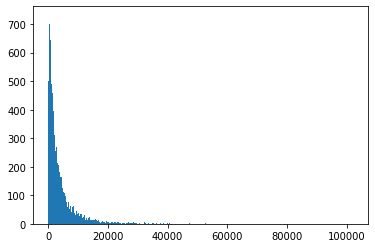

,count,mean,std,min,25%,50%,75%,max
0,10852.0,4278.588555,6562.800402,6.0,867.75,2166.0,4923.25,101989.0


In [19]:
plt.hist(np.abs(train_wifi_count_per_txt), bins=500)
plt.show()
pd.DataFrame(np.abs(train_wifi_count_per_txt)).describe().T

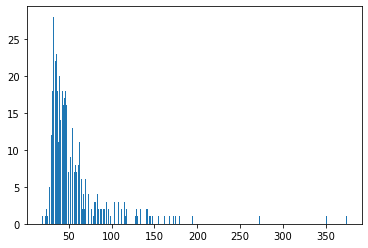

,count,mean,std,min,25%,50%,75%,max
0,626.0,60.188498,40.749258,19.0,36.0,46.5,64.75,374.0


In [28]:
plt.hist(np.abs(test_wifi_count_per_txt), bins=500)
plt.show()
pd.DataFrame(np.abs(test_wifi_count_per_txt)).describe().T

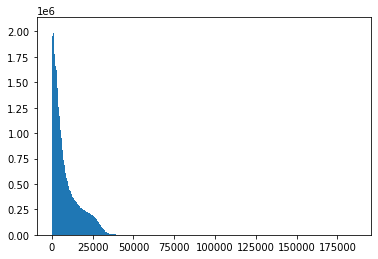

,count,mean,std,min,25%,50%,75%,max
0,46431243.0,8448.22299,8127.158008,0.0,2275.0,5425.0,12530.0,186509.0


In [21]:
plt.hist(np.abs(train_time_diffs), bins=500)
plt.show()
pd.DataFrame(np.abs(train_time_diffs)).describe().T

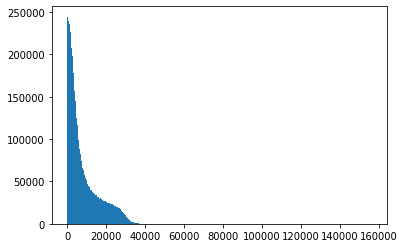

,count,mean,std,min,25%,50%,75%,max
0,6170798.0,8030.078438,7967.386296,0.0,2052.0,4871.0,11882.0,156361.0


In [28]:
plt.hist(np.abs(test_time_diffs), bins=500)
plt.show()
pd.DataFrame(np.abs(test_time_diffs)).describe().T

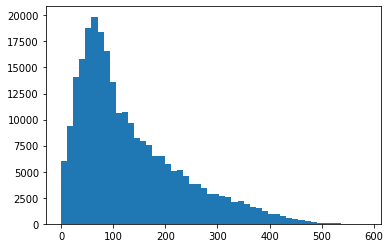

,count,mean,std,min,25%,50%,75%,max
0,258125.0,132.756808,99.001421,0.0,59.0,102.0,186.0,584.0


In [23]:
plt.hist(train_wifi_count, bins=50)
plt.show()
pd.DataFrame(train_wifi_count).describe().T

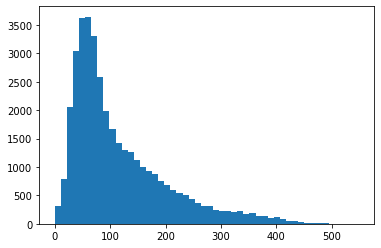

,count,mean,std,min,25%,50%,75%,max
0,37678.0,115.556054,87.086456,0.0,53.0,85.0,155.0,549.0


In [29]:
plt.hist(test_wifi_count, bins=50)
plt.show()
pd.DataFrame(test_wifi_count).describe().T

In [30]:
test_wifi_count_np = np.array(test_wifi_count)
print('WiFi10件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np <= 10])))
print('WiFi20件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np <= 20])))

WiFi10件以下の件数:306
WiFi20件以下の件数:987


In [31]:
pd.Series(test_wifi_count).value_counts().sort_index()

0      192
1        4
2        4
3        3
4        5
      ... 
522      1
524      1
528      1
542      1
549      1
Length: 496, dtype: int64